In [1]:
# Credit Card Fraud Detection
# Dataset Link: https://www.kaggle.com/dalpozz/creditcardfraud
# Dataset Size: 68 MB

import os, sys
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Fix seed for reproducibility 
seed = 24
np.random.seed(seed)
print("*MESSAGE* Random seed: {}".format(seed))

*MESSAGE* Random seed: 24


In [3]:
# Load data from csv into pandas dataframe
def load_data(csv_data,ratio=0.1):
    # Read the csv nd extract all the required info
    dataframe = pd.read_csv(csv_data)
    num_pos = dataframe[dataframe['Class']==1].shape[0]
    num_neg = dataframe.shape[0]-num_pos

    # Print the statics of Data
    print("Data statitics:")
    print(". # of samples        : {}".format(dataframe.shape[0]))
    print(". # of features       : {}".format(dataframe.shape[1]-1))
    print(". # of +ve/-ve samples: {}/{}".format(num_pos,num_neg))

    message = ("*MESSAGE* As you can see, out dataset is highly skewed: "
               "only {0:.3f}% of data is +ve".format(num_pos*100/(num_pos+num_neg)))
    print(message)

    return dataframe

In [4]:
csv_data = "creditcard.csv"
data = load_data(csv_data)
data.head()

Data statitics:
. # of samples        : 284807
. # of features       : 30
. # of +ve/-ve samples: 492/284315
*MESSAGE* As you can see, out dataset is highly skewed: only 0.173% of data is +ve


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
"""
Data set has a column 'Amount', which is not normalised
So, we normalise the 'Amount' column and drop the original 'Amount' Column
Further, since the data is highly skewed, we undersample it 
"""
def preprocess_FollowUnderSampling(data,ratio=4):
    print("*MESSAGE* Ratio of underSampling is {}:1".format(ratio))
    data['NormalisedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    data = data.drop(['Time','Amount'],axis=1)

    # Undersampling Steps
    fraud_count = len(data[data.Class==1])
    fraud_indices = data[data.Class==1].index
    notFraud_indices = data[data.Class==0].index
    rand_notFraud_indices = notFraud_indices[np.random.permutation(len(notFraud_indices))]
    rand_notFraud_indices_undersampled = rand_notFraud_indices[0:ratio*fraud_count]
    undersampled_indices = np.concatenate([fraud_indices,rand_notFraud_indices_undersampled])
    undersampled_data = data.iloc[undersampled_indices,:]
    X_undersampled = undersampled_data.iloc[:,undersampled_data.columns!='Class']
    Y_undersampled = undersampled_data.iloc[:,undersampled_data.columns=='Class']
    return X_undersampled,Y_undersampled

In [6]:
"""
X,Y are pandas dataframes
"""
def get_tr_tst(X,Y,ratio=0.10):
    X = X.as_matrix()
    Y = Y.as_matrix()
    indices = np.random.permutation(X.shape[0])
    split_index = int(ratio*indices.size)
    tst_data = X[indices[0:split_index],:]
    tst_lb = Y[indices[0:split_index]]
    tst_lb.shape = (tst_lb.size,)
    tr_data = X[indices[split_index:],:]
    tr_lb = Y[indices[split_index:]]
    tr_lb.shape = (tr_lb.size,)
    print("Statitics:")
    print(". # of train/test samples: {}/{}".format(tr_lb.size,tst_lb.size))
    return tr_data,tr_lb,tst_data,tst_lb

*MESSAGE* Ratio of underSampling is 1:1
Statitics:
. # of train/test samples: 886/98
*MESSAGE* Ratio of underSampling is 2:1
Statitics:
. # of train/test samples: 1329/147
*MESSAGE* Ratio of underSampling is 3:1
Statitics:
. # of train/test samples: 1772/196
*MESSAGE* Ratio of underSampling is 4:1
Statitics:
. # of train/test samples: 2214/246
*MESSAGE* Ratio of underSampling is 5:1
Statitics:
. # of train/test samples: 2657/295


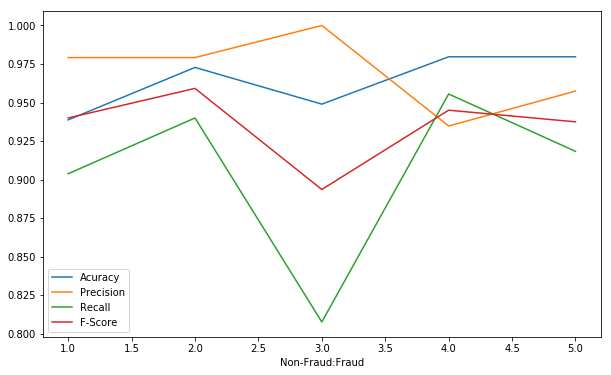

In [7]:
"""
We don't know, how much undersampling of non-fraud transactions will be good enough
May be a ratio of 1:1 .. but too less data
May be a ration of 10:1 .. but too much of unbalance
Let's plot the accuracy, precision, recall and f-score for various ratio values
A ratio of 3 or 4 looks good, we have taken 4
"""
def plot_underSamplingInfo(data):
    mySVM = SVC(C=1,kernel='poly',class_weight='balanced')
    max_ratio = 5
    accuracy = [0]*max_ratio
    precision = [0]*max_ratio
    recall = [0]*max_ratio
    fscore = [0]*max_ratio
    for i in range(max_ratio):
        X,Y = preprocess_FollowUnderSampling(data,i+1)
        tr_data,tr_lb,tst_data,tst_lb = get_tr_tst(X,Y)
        pred = mySVM.fit(tr_data,tr_lb).predict(tst_data)
        count = 0
        for j in range(pred.size):
            if pred[j]==tst_lb[j]: count += 1
        accuracy[i] = count/pred.size
        precision[i],recall[i],fscore[i] = precision_recall_fscore_support(tst_lb,pred,average='binary')[0:3]
    x = [i+1 for i in range(max_ratio)]
    plt.plot(x,accuracy,label='Acuracy')
    plt.plot(x,precision,label='Precision')
    plt.plot(x,recall,label='Recall')
    plt.plot(x,fscore,label='F-Score')
    plt.xlabel('Non-Fraud:Fraud')
    plt.legend(loc="lower left")
    plt.show()
plot_underSamplingInfo(data)

In [8]:
X,Y = preprocess_FollowUnderSampling(data)
tr_data,tr_lb,tst_data,tst_lb = get_tr_tst(X,Y)

*MESSAGE* Ratio of underSampling is 4:1
Statitics:
. # of train/test samples: 2214/246


In [9]:
"""
SVM has some hyper-parameters and is still considered one of the best classifiers
The other thing to look for is what kernel performs best and it totally depends on data
Our options are 'rbf', 'poly', and 'sigmoid'
We have skipped 'linear' because due to skewness of data set
'linear' seemed to trivial
Hyper-parameter Optimization: The below function deals with finding the best hyper-parameters
for a given kernel
We have used grid-search. Other option is bayesian but we couldn't find any known implementation
"""
def svm(tr_data,tr_lb,tst_data,tst_lb,kernel='rbf'):
    print("*MESSAGE* kernel = {}".format(kernel))
    mySVM = SVC(kernel=kernel,class_weight='balanced')
    C_range = [0.01,0.1,1,10,100,1000,10000]
    param_grid = dict(C=C_range)
    #param_grid
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
    clf = GridSearchCV(mySVM, param_grid=param_grid, cv=cv, n_jobs=-1)
    clf.fit(tr_data,tr_lb)
    message = ("*MESSAGE* Best C: {}, Score: {}".format(clf.best_params_['C'],clf.best_score_))
    print(message)
    pred = clf.predict(tst_data)
    count = 0
    for i in range(pred.size):
        if pred[i]==tst_lb[i]: count += 1
    print("*MESSAGE* Accuracy: {}".format(count/tst_lb.size))
    precision,recall,fscore = precision_recall_fscore_support(tst_lb,pred,average='binary')[0:3]
    print("*MESSAGE* Precision: {}, Recall: {}, F-score: {}".format(precision,recall,fscore))

svm(tr_data,tr_lb,tst_data,tst_lb)
svm(tr_data,tr_lb,tst_data,tst_lb,'poly')
svm(tr_data,tr_lb,tst_data,tst_lb,'sigmoid')

*MESSAGE* kernel = rbf
*MESSAGE* Best C: 1, Score: 0.9630630630630631
*MESSAGE* Accuracy: 0.9715447154471545
*MESSAGE* Precision: 0.9215686274509803, Recall: 0.94, F-score: 0.9306930693069307
*MESSAGE* kernel = poly
*MESSAGE* Best C: 0.1, Score: 0.9630630630630631
*MESSAGE* Accuracy: 0.975609756097561
*MESSAGE* Precision: 0.9782608695652174, Recall: 0.9, F-score: 0.9375
*MESSAGE* kernel = sigmoid
*MESSAGE* Best C: 0.01, Score: 0.8405405405405405
*MESSAGE* Accuracy: 0.8943089430894309
*MESSAGE* Precision: 0.6875, Recall: 0.88, F-score: 0.7719298245614036


In [10]:
# Here we can see that polynomial kernel performs best with C = 1
# Now we will use this to build out final SVM based model, plot 
# confusion matrix, plot ROC and calculate AUC
# Code taken from here: https://goo.gl/DcMhma 

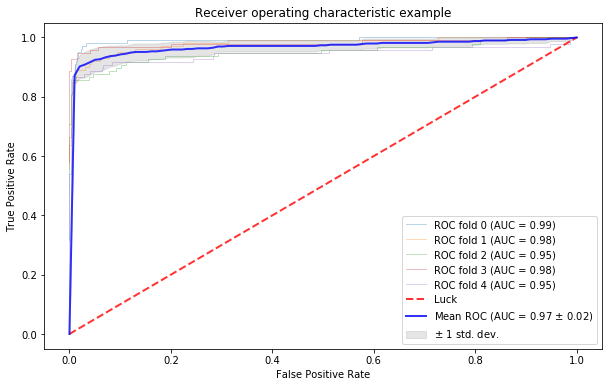

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(n_splits=5)
classifier = SVC(C=1, kernel='poly', probability=True)
tprs,aucs = [],[]
mean_fpr = np.linspace(0, 1, 100)
i = 0
X_,Y_ = X.as_matrix(),Y.as_matrix()
Y_.shape = (Y_.size,)
for train, test in cv.split(X_, Y_):
    probas_ = classifier.fit(X_[train], Y_[train]).predict_proba(X_[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()